# 🔬 Nghiên Cứu Phương Pháp Điều Chỉnh Bias cho PatchTST với Optuna

Notebook này nghiên cứu các phương pháp **thuật toán** để điều chỉnh bias của PatchTST với:
1. **Optuna** để tối ưu hyperparameters cho PatchTST
2. **Bias Correction Methods** để cải thiện predictions:
   - **Bias Correction**: Trừ bias trung bình
   - **Residual Correction Model**: Train model phụ để dự đoán residuals
   - **Isotonic Calibration**: Calibrate predictions
   - **Post-processing Regression**: Linear regression để điều chỉnh
3. So sánh và chọn phương pháp tốt nhất

## Nguyên tắc:
- **KHÔNG hardcode** giá trị
- Chỉ sử dụng **thuật toán** và **dữ liệu thực tế**
- Tất cả điều chỉnh phải được **học từ dữ liệu**
- Sử dụng **Optuna** để tối ưu hyperparameters


## 1. Setup và Import Libraries


In [1]:
# Cài đặt các thư viện cần thiết
import subprocess
import sys

def install_package(package, import_name=None):
    """Cài đặt package nếu chưa có"""
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
        print(f"✓ {package} đã được cài đặt")
        return True
    except ImportError:
        print(f"📦 Đang cài đặt {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package], 
                                 stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"✓ Đã cài đặt {package}")
            return True
        except Exception as e:
            print(f"⚠️  Lỗi khi cài đặt {package}: {e}")
            return False

# Cài đặt các thư viện cần thiết
packages_to_install = [
    ('neuralforecast', 'neuralforecast'),
    ('optuna', 'optuna'),
    ('scikit-learn', 'sklearn'),
    ('scipy', 'scipy')
]

print("🔧 Kiểm tra và cài đặt các thư viện cần thiết...\n")
for package, import_name in packages_to_install:
    install_package(package, import_name)

print("\n✓ Hoàn thành kiểm tra/cài đặt thư viện!")


🔧 Kiểm tra và cài đặt các thư viện cần thiết...

✓ neuralforecast đã được cài đặt
✓ optuna đã được cài đặt
✓ scikit-learn đã được cài đặt
✓ scipy đã được cài đặt

✓ Hoàn thành kiểm tra/cài đặt thư viện!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import TimeSeriesSplit
import os
from pathlib import Path

# Set encoding để tránh lỗi Unicode
import sys
import io
if sys.platform == 'win32':
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')
    sys.stderr = io.TextIOWrapper(sys.stderr.buffer, encoding='utf-8')

# NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
import optuna
from optuna import Trial
import torch

print("✓ Đã import các thư viện cần thiết")


✓ Đã import các thư viện cần thiết


## 2. Load và Chuẩn Bị Dữ Liệu


In [3]:
# Load dữ liệu training
csv_path = Path("./FPT_train.csv")
if not csv_path.exists():
    # Thử download từ Google Drive
    from pathlib import Path
    import subprocess
    DRIVE_FILE_ID = "1nS9xshut38SJEX__PD_zjKFtj2CQCn7S"
    try:
        import gdown
        gdown.download(f"https://drive.google.com/uc?id={DRIVE_FILE_ID}", str(csv_path), quiet=False)
    except:
        print("⚠️  Vui lòng đảm bảo file FPT_train.csv tồn tại")
        raise

df = pd.read_csv(csv_path, parse_dates=["time"])
df = df.sort_values("time").reset_index(drop=True)

print(f"✓ Đã load dữ liệu training: {len(df)} điểm")
print(f"   - Từ {df['time'].min()} đến {df['time'].max()}")

# Chuẩn bị dữ liệu
target_col = "close"
horizon = 100  # Dự đoán 100 ngày tiếp theo

close_values = df[target_col].values.astype("float32")
T = len(close_values)

# Chia train/validation (không chia test từ training data)
# Train: 80%, Val: 10%
train_size = int(T * 0.8)
val_size = int(T * 0.1)

train_data = close_values[:train_size]
val_data = close_values[train_size:train_size + val_size]

print(f"\n📊 Chia dữ liệu training:")
print(f"   - Train: {len(train_data)} điểm")
print(f"   - Val: {len(val_data)} điểm")


✓ Đã load dữ liệu training: 1149 điểm
   - Từ 2020-08-03 00:00:00 đến 2025-03-10 00:00:00

📊 Chia dữ liệu training:
   - Train: 919 điểm
   - Val: 114 điểm


In [4]:
# Download và load file test từ Google Drive
from pathlib import Path
import subprocess

# Google Drive file ID cho file test/ground truth
TEST_FILE_ID = "1IkzoSTHPMnOUBILN7cCPjVw9QWAuOtCs"
test_file_path = Path("./FPT_test.csv")

# Download file test
if test_file_path.exists():
    print(f"✓ File test đã tồn tại tại: {test_file_path}")
else:
    print("📥 Đang download file test từ Google Drive...")
    
    try:
        try:
            import gdown
        except ImportError:
            print("   Đang cài đặt gdown...")
            subprocess.run(["pip", "install", "-q", "gdown"], check=True)
            import gdown
        
        gdown.download(f"https://drive.google.com/uc?id={TEST_FILE_ID}", str(test_file_path), quiet=False)
        
        if test_file_path.exists():
            print(f"✓ Đã download file test thành công tại: {test_file_path}")
        else:
            raise Exception("Download không thành công")
    except Exception as e:
        print(f"❌ Lỗi khi download: {e}")
        raise

# Đọc và lọc file test theo symbol FPT và đúng ngày
df_test_raw = pd.read_csv(test_file_path, parse_dates=["time"] if "time" in pd.read_csv(test_file_path, nrows=1).columns else None)

print(f"\n📊 Cấu trúc file test (trước khi lọc):")
print(f"   - Tổng số dòng: {len(df_test_raw):,}")

# Lọc theo symbol FPT
if "symbol" in df_test_raw.columns:
    df_test = df_test_raw[df_test_raw["symbol"] == "FPT"].copy()
    print(f"   - Sau khi lọc theo symbol='FPT': {len(df_test):,} dòng")
    
    # Sắp xếp theo thời gian
    if "time" in df_test.columns:
        df_test = df_test.sort_values("time").reset_index(drop=True)
        
        # Lấy ngày cuối cùng từ training data để lọc đúng ngày
        last_train_date = df["time"].max()
        print(f"   - Ngày cuối cùng trong training: {last_train_date.strftime('%Y-%m-%d')}")
        
        # Lọc các ngày sau ngày cuối cùng của training
        df_test = df_test[df_test["time"] > last_train_date].copy()
        df_test = df_test.sort_values("time").reset_index(drop=True)
        print(f"   - Sau khi lọc ngày > {last_train_date.strftime('%Y-%m-%d')}: {len(df_test):,} dòng")
else:
    print("⚠️  File không có cột 'symbol'. Sử dụng toàn bộ file:")
    df_test = df_test_raw.copy()
    if "time" in df_test.columns:
        df_test = df_test.sort_values("time").reset_index(drop=True)

# Chuẩn bị dữ liệu cho NeuralForecast
train_nf = pd.DataFrame({
    'unique_id': 'FPT',
    'ds': pd.date_range(start=df['time'].iloc[0], periods=len(train_data), freq='D'),
    'y': train_data
})

val_nf = pd.DataFrame({
    'unique_id': 'FPT',
    'ds': pd.date_range(start=df['time'].iloc[train_size], periods=len(val_data), freq='D'),
    'y': val_data
})

# Full train (train + val) để train final model
train_nf_full = pd.concat([train_nf, val_nf], ignore_index=True)

# Ground truth từ file test (100 ngày đầu tiên)
if 'df_test' in globals() and df_test is not None and len(df_test) >= horizon:
    y_true = df_test.head(horizon)["close"].values.astype("float32")
    print(f"\n✓ Đã lấy {len(y_true)} điểm ground truth từ test data để đánh giá")
elif 'df_test' in globals() and df_test is not None and len(df_test) > 0:
    y_true = df_test["close"].values.astype("float32")
    print(f"\n✓ Đã lấy {len(y_true)} điểm ground truth từ test data (ít hơn {horizon} điểm)")
else:
    # Fallback: sử dụng validation data nếu không có test data
    y_true = val_data[:min(horizon, len(val_data))]
    print(f"\n⚠️  Không có test data, sử dụng validation data: {len(y_true)} điểm")

print(f"\n✓ Đã chuẩn bị dữ liệu cho NeuralForecast")
print(f"   - Train: {len(train_nf)} điểm")
print(f"   - Val: {len(val_nf)} điểm")
print(f"   - Test ground truth: {len(y_true)} điểm")


✓ File test đã tồn tại tại: FPT_test.csv

📊 Cấu trúc file test (trước khi lọc):
   - Tổng số dòng: 4,638,725
   - Sau khi lọc theo symbol='FPT': 4,712 dòng
   - Ngày cuối cùng trong training: 2025-03-10
   - Sau khi lọc ngày > 2025-03-10: 168 dòng

✓ Đã lấy 100 điểm ground truth từ test data để đánh giá

✓ Đã chuẩn bị dữ liệu cho NeuralForecast
   - Train: 919 điểm
   - Val: 114 điểm
   - Test ground truth: 100 điểm


## 3. Tối Ưu Hyperparameters với Optuna cho PatchTST


In [5]:
print("="*70)
print("🔧 TỐI ƯU HYPERPARAMETERS VỚI OPTUNA CHO PATCHTST")
print("="*70)

# Chia dữ liệu cho Optuna optimization
# Dùng 90% đầu để train, 10% cuối để validation
optuna_train_size = int(len(train_nf_full) * 0.9)
train_nf_optuna = train_nf_full.iloc[:optuna_train_size].copy()
val_nf_optuna = train_nf_full.iloc[optuna_train_size:].copy()

# Lấy validation ground truth để đánh giá trong Optuna
val_close_optuna = val_nf_optuna["y"].values.astype("float32")

print(f"\n📊 Dữ liệu cho optimization:")
print(f"   - Train cho Optuna: {len(train_nf_optuna)} điểm (90%)")
print(f"   - Val cho Optuna: {len(val_nf_optuna)} điểm (10%)")
print(f"   - Horizon: {horizon}")
print(f"\n💡 Optuna sẽ tối ưu hyperparameters cho PatchTST")
print(f"   Sau khi tìm được best params, sẽ train final model trên TOÀN BỘ {len(train_nf_full)} điểm.")


🔧 TỐI ƯU HYPERPARAMETERS VỚI OPTUNA CHO PATCHTST

📊 Dữ liệu cho optimization:
   - Train cho Optuna: 929 điểm (90%)
   - Val cho Optuna: 104 điểm (10%)
   - Horizon: 100

💡 Optuna sẽ tối ưu hyperparameters cho PatchTST
   Sau khi tìm được best params, sẽ train final model trên TOÀN BỘ 1033 điểm.


In [6]:
# Objective function cho Optuna
def objective_patchtst(trial: Trial):
    """Objective function cho PatchTST optimization"""
    # Suggest hyperparameters
    input_size = trial.suggest_int("input_size", 100, 300, step=50)
    patch_len = trial.suggest_int("patch_len", 8, 32, step=8)
    stride = trial.suggest_int("stride", 4, 16, step=4)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    max_steps = trial.suggest_int("max_steps", 50, 300, step=50)
    
    try:
        model = PatchTST(
            h=min(horizon, len(val_nf_optuna)),
            input_size=input_size,
            patch_len=patch_len,
            stride=stride,
            revin=True,
            learning_rate=learning_rate,
            max_steps=max_steps,
            val_check_steps=10,
        )
        
        nf_model = NeuralForecast(models=[model], freq='D')
        nf_model.fit(df=train_nf_optuna, val_size=0)
        forecast = nf_model.predict()
        
        # Lấy predictions
        pred_col = [col for col in forecast.columns if col not in ['unique_id', 'ds']][0]
        pred = forecast[pred_col].values
        
        # Chỉ lấy số điểm tương ứng với validation
        n_points = min(len(pred), len(val_close_optuna), horizon)
        pred = pred[:n_points]
        val_true = val_close_optuna[:n_points]
        
        # Tính MSE
        mse = mean_squared_error(val_true, pred)
        return mse
    except Exception as e:
        print(f"   ⚠️  Lỗi trong trial: {e}")
        return float('inf')

# Tạo study và optimize
study_patchtst = optuna.create_study(direction='minimize', study_name='PatchTST_Optuna')
print(f"\n🔄 Đang tối ưu PatchTST với Optuna (20 trials)...")
print("   ⏳ Quá trình này có thể mất vài phút...\n")

study_patchtst.optimize(objective_patchtst, n_trials=20, show_progress_bar=True)

# Lưu best parameters
best_params_patchtst = study_patchtst.best_params

print(f"\n✅ Best parameters cho PatchTST:")
for key, value in best_params_patchtst.items():
    print(f"   - {key}: {value}")
print(f"   - Best MSE: {study_patchtst.best_value:.4f}")


[I 2025-12-02 02:03:46,965] A new study created in memory with name: PatchTST_Optuna



🔄 Đang tối ưu PatchTST với Optuna (20 trials)...
   ⏳ Quá trình này có thể mất vài phút...



  0%|          | 0/20 [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  854 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 854 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 854 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:04:01,440] Trial 0 finished with value: 726.5036010742188 and parameters: {'input_size': 300, 'patch_len': 32, 'stride': 8, 'learning_rate': 0.004090000185953641, 'max_steps': 100}. Best is trial 0 with value: 726.5036010742188.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  619 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 619 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 619 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:04:06,856] Trial 1 finished with value: 374.3765869140625 and parameters: {'input_size': 200, 'patch_len': 16, 'stride': 12, 'learning_rate': 0.00193548250810536, 'max_steps': 100}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  1.3 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 1.3 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:04:28,147] Trial 2 finished with value: 894.3941650390625 and parameters: {'input_size': 300, 'patch_len': 24, 'stride': 4, 'learning_rate': 0.0007674300957022012, 'max_steps': 100}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  645 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 645 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 645 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=250` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:04:41,902] Trial 3 finished with value: 420.91424560546875 and parameters: {'input_size': 300, 'patch_len': 16, 'stride': 16, 'learning_rate': 0.008935927227645558, 'max_steps': 250}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  734 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 734 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 734 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:04:45,592] Trial 4 finished with value: 650.3121337890625 and parameters: {'input_size': 200, 'patch_len': 8, 'stride': 8, 'learning_rate': 0.00014577408129911137, 'max_steps': 50}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  527 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 527 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 527 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:04:51,787] Trial 5 finished with value: 790.91650390625 and parameters: {'input_size': 150, 'patch_len': 8, 'stride': 16, 'learning_rate': 0.00425056867963967, 'max_steps': 200}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  1.2 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 1.2 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 1.2 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:08,166] Trial 6 finished with value: 890.8834228515625 and parameters: {'input_size': 250, 'patch_len': 24, 'stride': 4, 'learning_rate': 0.0003738711296416096, 'max_steps': 100}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  619 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 619 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 619 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:13,471] Trial 7 finished with value: 755.4712524414062 and parameters: {'input_size': 200, 'patch_len': 16, 'stride': 12, 'learning_rate': 0.00012810595978716266, 'max_steps': 100}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  878 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 878 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 878 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:23,406] Trial 8 finished with value: 702.8936157226562 and parameters: {'input_size': 300, 'patch_len': 16, 'stride': 8, 'learning_rate': 0.004744437963044401, 'max_steps': 100}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  634 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 634 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 634 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:31,517] Trial 9 finished with value: 547.4508056640625 and parameters: {'input_size': 300, 'patch_len': 32, 'stride': 16, 'learning_rate': 0.0048179820241546845, 'max_steps': 150}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  515 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 515 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 515 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=300` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:40,629] Trial 10 finished with value: 440.042236328125 and parameters: {'input_size': 100, 'patch_len': 8, 'stride': 12, 'learning_rate': 0.001384203780227732, 'max_steps': 300}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  606 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 606 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 606 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=250` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:50,000] Trial 11 finished with value: 642.6422119140625 and parameters: {'input_size': 250, 'patch_len': 16, 'stride': 16, 'learning_rate': 0.008964913204139441, 'max_steps': 250}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  567 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 567 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 567 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:05:56,864] Trial 12 finished with value: 500.6235656738281 and parameters: {'input_size': 150, 'patch_len': 16, 'stride': 12, 'learning_rate': 0.0018956521316201816, 'max_steps': 200}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  607 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 607 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 607 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=300` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:06:08,160] Trial 13 finished with value: 594.63330078125 and parameters: {'input_size': 250, 'patch_len': 24, 'stride': 16, 'learning_rate': 0.009452096934559753, 'max_steps': 300}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  567 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 567 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 567 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=250` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:06:16,631] Trial 14 finished with value: 506.1262512207031 and parameters: {'input_size': 150, 'patch_len': 16, 'stride': 12, 'learning_rate': 0.0006233968177805288, 'max_steps': 250}. Best is trial 1 with value: 374.3765869140625.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:06:21,732] Trial 15 finished with value: 261.99017333984375 and parameters: {'input_size': 200, 'patch_len': 24, 'stride': 16, 'learning_rate': 0.0021189000559476813, 'max_steps': 150}. Best is trial 15 with value: 261.99017333984375.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  607 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 607 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 607 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:06:27,466] Trial 16 finished with value: 404.69940185546875 and parameters: {'input_size': 200, 'patch_len': 24, 'stride': 12, 'learning_rate': 0.002010991372232365, 'max_steps': 150}. Best is trial 15 with value: 261.99017333984375.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  479 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 479 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 479 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:06:31,759] Trial 17 finished with value: 471.06512451171875 and parameters: {'input_size': 100, 'patch_len': 32, 'stride': 16, 'learning_rate': 0.0004121281949271523, 'max_steps': 150}. Best is trial 15 with value: 261.99017333984375.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  555 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 555 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 555 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-12-02 02:06:33,548] Trial 18 finished with value: 398.3490295410156 and parameters: {'input_size': 150, 'patch_len': 24, 'stride': 12, 'learning_rate': 0.002139474672607497, 'max_steps': 50}. Best is trial 15 with value: 261.99017333984375.


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  711 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 711 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 711 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

[I 2025-12-02 02:06:36,887] Trial 19 finished with value: 417.1183166503906 and parameters: {'input_size': 200, 'patch_len': 24, 'stride': 8, 'learning_rate': 0.0011481853818053015, 'max_steps': 50}. Best is trial 15 with value: 261.99017333984375.

✅ Best parameters cho PatchTST:
   - input_size: 200
   - patch_len: 24
   - stride: 16
   - learning_rate: 0.0021189000559476813
   - max_steps: 150
   - Best MSE: 261.9902


## 4. Train PatchTST Baseline Model với Best Parameters


In [7]:
# Train PatchTST với best parameters từ Optuna trên TOÀN BỘ dữ liệu
print("="*70)
print("🔧 TRAINING PATCHTST BASELINE MODEL VỚI BEST PARAMETERS")
print("="*70)

# Train trên train + val để có model tốt nhất
model_patchtst = PatchTST(
    h=horizon,
    input_size=best_params_patchtst['input_size'],
    patch_len=best_params_patchtst['patch_len'],
    stride=best_params_patchtst['stride'],
    revin=True,
    learning_rate=best_params_patchtst['learning_rate'],
    max_steps=best_params_patchtst['max_steps'],
    val_check_steps=10,
)

nf_patchtst = NeuralForecast(models=[model_patchtst], freq='D')
nf_patchtst.fit(df=train_nf_full, val_size=0)  # Dùng toàn bộ data để train
forecast_patchtst = nf_patchtst.predict()

# Lấy predictions
pred_col = [col for col in forecast_patchtst.columns if col not in ['unique_id', 'ds']][0]
pred_patchtst_baseline = forecast_patchtst[pred_col].values[:len(y_true)]

# Đánh giá baseline
mse_baseline = mean_squared_error(y_true, pred_patchtst_baseline)
mae_baseline = mean_absolute_error(y_true, pred_patchtst_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_true, pred_patchtst_baseline)
mape_baseline = np.mean(np.abs((y_true - pred_patchtst_baseline) / y_true)) * 100

# Tính bias
bias_baseline = np.mean(pred_patchtst_baseline - y_true)
mean_abs_bias = np.mean(np.abs(pred_patchtst_baseline - y_true))

print(f"\n📊 PatchTST Baseline Results:")
print(f"   - MSE: {mse_baseline:.4f}")
print(f"   - RMSE: {rmse_baseline:.4f}")
print(f"   - MAE: {mae_baseline:.4f}")
print(f"   - R²: {r2_baseline:.4f}")
print(f"   - MAPE: {mape_baseline:.2f}%")
print(f"   - Bias (mean error): {bias_baseline:.4f}")
print(f"   - Mean |Error|: {mean_abs_bias:.4f}")
print(f"\n💡 Phân tích:")
if bias_baseline > 0:
    print(f"   - Model đang OVERESTIMATE (dự đoán cao hơn thực tế) trung bình {bias_baseline:.2f} điểm")
    print(f"   - Cần điều chỉnh để kéo predictions xuống")
else:
    print(f"   - Model đang UNDERESTIMATE (dự đoán thấp hơn thực tế) trung bình {abs(bias_baseline):.2f} điểm")
    print(f"   - Cần điều chỉnh để kéo predictions lên")


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔧 TRAINING PATCHTST BASELINE MODEL VỚI BEST PARAMETERS


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()


📊 PatchTST Baseline Results:
   - MSE: 407.5120
   - RMSE: 20.1869
   - MAE: 18.9428
   - R²: -10.7713
   - MAPE: 18.59%
   - Bias (mean error): 18.8494
   - Mean |Error|: 18.9428

💡 Phân tích:
   - Model đang OVERESTIMATE (dự đoán cao hơn thực tế) trung bình 18.85 điểm
   - Cần điều chỉnh để kéo predictions xuống


In [8]:
print("="*70)
print("🔧 ÁP DỤNG BIAS CORRECTION METHODS CHO PATCHTST")
print("="*70)

# Dictionary để lưu tất cả bias correction predictions
all_bias_correction_predictions = {}

print(f"\n📊 PatchTST Baseline:")
print(f"   - MSE: {mse_baseline:.4f}")
print(f"   - Bias: {bias_baseline:.4f}")


🔧 ÁP DỤNG BIAS CORRECTION METHODS CHO PATCHTST

📊 PatchTST Baseline:
   - MSE: 407.5120
   - Bias: 18.8494


### 5.1. Bias Correction (Trừ Bias Trung Bình)


In [9]:
print("="*70)
print("🔧 PHƯƠNG PHÁP 1: BIAS CORRECTION (Trừ Bias Trung Bình)")
print("="*70)

# Tính bias trên validation set sử dụng TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
bias_estimates = []

# Tính bias trên các validation folds
full_data = train_nf_full.copy()
for train_idx, val_idx in tscv.split(full_data):
    train_fold = full_data.iloc[train_idx]
    val_fold = full_data.iloc[val_idx]
    
    # Train model trên fold
    model_fold = PatchTST(
        h=min(horizon, len(val_fold)),
        input_size=best_params_patchtst['input_size'],
        patch_len=best_params_patchtst['patch_len'],
        stride=best_params_patchtst['stride'],
        revin=True,
        learning_rate=best_params_patchtst['learning_rate'],
        max_steps=best_params_patchtst['max_steps'],
        val_check_steps=10,
    )
    nf_fold = NeuralForecast(models=[model_fold], freq='D')
    nf_fold.fit(df=train_fold, val_size=0)
    forecast_fold = nf_fold.predict()
    
    pred_col = [col for col in forecast_fold.columns if col not in ['unique_id', 'ds']][0]
    pred_fold = forecast_fold[pred_col].values[:len(val_fold)]
    true_fold = val_fold['y'].values[:len(pred_fold)]
    
    # Tính bias
    bias_fold = np.mean(pred_fold - true_fold)
    bias_estimates.append(bias_fold)

# Tính bias trung bình
estimated_bias = np.mean(bias_estimates)

print(f"\n📊 Bias Estimates từ {len(bias_estimates)} folds:")
for i, bias in enumerate(bias_estimates, 1):
    print(f"   - Fold {i}: {bias:.4f}")
print(f"   - Mean Bias: {estimated_bias:.4f}")

# Áp dụng bias correction
pred_bias_corrected = pred_patchtst_baseline - estimated_bias
all_bias_correction_predictions['BiasCorrection'] = pred_bias_corrected

# Đánh giá
mse_bias_corr = mean_squared_error(y_true, pred_bias_corrected)
mae_bias_corr = mean_absolute_error(y_true, pred_bias_corrected)
rmse_bias_corr = np.sqrt(mse_bias_corr)
r2_bias_corr = r2_score(y_true, pred_bias_corrected)
mape_bias_corr = np.mean(np.abs((y_true - pred_bias_corrected) / y_true)) * 100
bias_after = np.mean(pred_bias_corrected - y_true)

print(f"\n📊 Kết quả sau Bias Correction:")
print(f"   - MSE: {mse_bias_corr:.4f} (Baseline: {mse_baseline:.4f})")
print(f"   - RMSE: {rmse_bias_corr:.4f} (Baseline: {rmse_baseline:.4f})")
print(f"   - MAE: {mae_bias_corr:.4f} (Baseline: {mae_baseline:.4f})")
print(f"   - R²: {r2_bias_corr:.4f} (Baseline: {r2_baseline:.4f})")
print(f"   - MAPE: {mape_bias_corr:.2f}% (Baseline: {mape_baseline:.2f}%)")
print(f"   - Bias sau correction: {bias_after:.4f} (Baseline: {bias_baseline:.4f})")

improvement = ((mse_baseline - mse_bias_corr) / mse_baseline) * 100
print(f"\n💡 Cải thiện MSE: {improvement:+.2f}%")


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔧 PHƯƠNG PHÁP 1: BIAS CORRECTION (Trừ Bias Trung Bình)


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()


📊 Bias Estimates từ 3 folds:
   - Fold 1: 1.7471
   - Fold 2: 4.3693
   - Fold 3: 7.3060
   - Mean Bias: 4.4742

📊 Kết quả sau Bias Correction:
   - MSE: 258.8595 (Baseline: 407.5120)
   - RMSE: 16.0891 (Baseline: 20.1869)
   - MAE: 14.7612 (Baseline: 18.9428)
   - R²: -6.4774 (Baseline: -10.7713)
   - MAPE: 14.50% (Baseline: 18.59%)
   - Bias sau correction: 14.3752 (Baseline: 18.8494)

💡 Cải thiện MSE: +36.48%


In [10]:
print("="*70)
print("🔧 PHƯƠNG PHÁP 2: POST-PROCESSING REGRESSION")
print("="*70)

# Train linear regression để map predictions -> actual values
tscv = TimeSeriesSplit(n_splits=3)
X_post = []
y_post = []

full_data = train_nf_full.copy()
for train_idx, val_idx in tscv.split(full_data):
    train_fold = full_data.iloc[train_idx]
    val_fold = full_data.iloc[val_idx]
    
    model_fold = PatchTST(
        h=min(horizon, len(val_fold)),
        input_size=best_params_patchtst['input_size'],
        patch_len=best_params_patchtst['patch_len'],
        stride=best_params_patchtst['stride'],
        revin=True,
        learning_rate=best_params_patchtst['learning_rate'],
        max_steps=best_params_patchtst['max_steps'],
        val_check_steps=10,
    )
    nf_fold = NeuralForecast(models=[model_fold], freq='D')
    nf_fold.fit(df=train_fold, val_size=0)
    forecast_fold = nf_fold.predict()
    
    pred_col = [col for col in forecast_fold.columns if col not in ['unique_id', 'ds']][0]
    pred_fold = forecast_fold[pred_col].values[:len(val_fold)]
    true_fold = val_fold['y'].values[:len(pred_fold)]
    
    X_post.extend(pred_fold.reshape(-1, 1))
    y_post.extend(true_fold)

X_post = np.array(X_post)
y_post = np.array(y_post)

print(f"\n📊 Đã thu thập {len(X_post)} điểm để train post-processing model")

# Train các regression models
post_models = {
    'Linear': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1),
}

post_results = []

for name, model in post_models.items():
    model.fit(X_post, y_post)
    
    # Predict
    pred_post = model.predict(pred_patchtst_baseline.reshape(-1, 1))
    
    # Đánh giá
    mse_post = mean_squared_error(y_true, pred_post)
    mae_post = mean_absolute_error(y_true, pred_post)
    rmse_post = np.sqrt(mse_post)
    r2_post = r2_score(y_true, pred_post)
    mape_post = np.mean(np.abs((y_true - pred_post) / y_true)) * 100
    bias_post = np.mean(pred_post - y_true)
    
    # Lấy coefficients
    if hasattr(model, 'coef_'):
        coef = model.coef_[0]
        intercept = model.intercept_
    else:
        coef = None
        intercept = None
    
    post_results.append({
        'method': name,
        'MSE': mse_post,
        'RMSE': rmse_post,
        'MAE': mae_post,
        'R²': r2_post,
        'MAPE': mape_post,
        'bias': bias_post,
        'coef': coef,
        'intercept': intercept,
        'prediction': pred_post.copy()
    })
    
    all_bias_correction_predictions[f'PostProcessing_{name}'] = pred_post
    
    improvement = ((mse_baseline - mse_post) / mse_baseline) * 100
    print(f"\n📊 Post-processing với {name}:")
    if coef is not None:
        print(f"   - Formula: y = {coef:.4f} * pred + {intercept:.4f}")
    print(f"   - MSE: {mse_post:.4f} (Baseline: {mse_baseline:.4f})")
    print(f"   - RMSE: {rmse_post:.4f}")
    print(f"   - Bias: {bias_post:.4f}")
    print(f"   - Cải thiện MSE: {improvement:+.2f}%")

# Tìm best post-processing
best_post = min(post_results, key=lambda x: x['MSE'])
print(f"\n🏆 Best Post-processing: {best_post['method']}")
print(f"   - MSE: {best_post['MSE']:.4f}")
if best_post['coef'] is not None:
    print(f"   - Formula: y = {best_post['coef']:.4f} * pred + {best_post['intercept']:.4f}")


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


🔧 PHƯƠNG PHÁP 2: POST-PROCESSING REGRESSION


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  568 K │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 568 K                                                                                            
Non-trainable params: 3                                                                                            
Total params: 568 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=150` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()


📊 Đã thu thập 300 điểm để train post-processing model

📊 Post-processing với Linear:
   - Formula: y = 0.7595 * pred + 9.9863
   - MSE: 42.1993 (Baseline: 407.5120)
   - RMSE: 6.4961
   - Bias: -0.5865
   - Cải thiện MSE: +89.64%

📊 Post-processing với Ridge (alpha=1.0):
   - Formula: y = 0.7595 * pred + 9.9873
   - MSE: 42.1999 (Baseline: 407.5120)
   - RMSE: 6.4961
   - Bias: -0.5876
   - Cải thiện MSE: +89.64%

📊 Post-processing với Ridge (alpha=10.0):
   - Formula: y = 0.7593 * pred + 9.9963
   - MSE: 42.2058 (Baseline: 407.5120)
   - RMSE: 6.4966
   - Bias: -0.5970
   - Cải thiện MSE: +89.64%

📊 Post-processing với Lasso (alpha=0.1):
   - Formula: y = 0.7588 * pred + 10.0261
   - MSE: 42.2262 (Baseline: 407.5120)
   - RMSE: 6.4982
   - Bias: -0.6278
   - Cải thiện MSE: +89.64%

🏆 Best Post-processing: Linear
   - MSE: 42.1993
   - Formula: y = 0.7595 * pred + 9.9863


## 6. So Sánh Tất Cả Phương Pháp


In [11]:
print("="*70)
print("📊 SO SÁNH TẤT CẢ PHƯƠNG PHÁP")
print("="*70)

# Tổng hợp tất cả kết quả
all_methods = []

# Baseline
all_methods.append({
    'Method': 'PatchTST Baseline',
    'Type': 'Baseline',
    'MSE': mse_baseline,
    'RMSE': rmse_baseline,
    'MAE': mae_baseline,
    'R²': r2_baseline,
    'MAPE': mape_baseline,
    'Bias': bias_baseline,
    'Prediction': pred_patchtst_baseline.copy()
})

# Bias Correction
all_methods.append({
    'Method': 'Bias Correction',
    'Type': 'Bias Correction',
    'MSE': mse_bias_corr,
    'RMSE': rmse_bias_corr,
    'MAE': mae_bias_corr,
    'R²': r2_bias_corr,
    'MAPE': mape_bias_corr,
    'Bias': bias_after,
    'Prediction': pred_bias_corrected.copy()
})

# Post-processing
for result in post_results:
    all_methods.append({
        'Method': f"Post-processing ({result['method']})",
        'Type': 'Post-processing',
        'MSE': result['MSE'],
        'RMSE': result['RMSE'],
        'MAE': result['MAE'],
        'R²': result['R²'],
        'MAPE': result['MAPE'],
        'Bias': result['bias'],
        'Prediction': result['prediction'].copy()
    })

# Tạo DataFrame và sắp xếp theo MSE
comparison_df = pd.DataFrame([{k: v for k, v in m.items() if k != 'Prediction'} for m in all_methods])
comparison_df = comparison_df.sort_values('MSE')

print("\n📈 BẢNG SO SÁNH TẤT CẢ PHƯƠNG PHÁP (sắp xếp theo MSE):")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Tìm best method
best_method = comparison_df.iloc[0]
best_method_full = next(m for m in all_methods if m['Method'] == best_method['Method'])

print(f"\n🏆 PHƯƠNG PHÁP TỐT NHẤT: {best_method['Method']}")
print(f"   - Type: {best_method['Type']}")
print(f"   - MSE: {best_method['MSE']:.4f}")
print(f"   - RMSE: {best_method['RMSE']:.4f}")
print(f"   - MAE: {best_method['MAE']:.4f}")
print(f"   - R²: {best_method['R²']:.4f}")
print(f"   - MAPE: {best_method['MAPE']:.2f}%")
print(f"   - Bias: {best_method['Bias']:.4f}")

baseline_method = comparison_df[comparison_df['Type'] == 'Baseline'].iloc[0]
improvement = ((baseline_method['MSE'] - best_method['MSE']) / baseline_method['MSE']) * 100
print(f"\n💡 So sánh với PatchTST Baseline:")
print(f"   - Baseline MSE: {baseline_method['MSE']:.4f}")
print(f"   - Best Method MSE: {best_method['MSE']:.4f}")
print(f"   - Cải thiện: {improvement:+.2f}%")

# Top 5 methods
print(f"\n🥇 TOP 5 PHƯƠNG PHÁP TỐT NHẤT:")
for i, (idx, row) in enumerate(comparison_df.head(5).iterrows(), 1):
    print(f"   {i}. {row['Method']} - MSE: {row['MSE']:.4f}, Type: {row['Type']}")


📊 SO SÁNH TẤT CẢ PHƯƠNG PHÁP

📈 BẢNG SO SÁNH TẤT CẢ PHƯƠNG PHÁP (sắp xếp theo MSE):
                              Method            Type        MSE      RMSE       MAE         R²      MAPE      Bias
            Post-processing (Linear) Post-processing  42.199303  6.496099  5.023886  -0.218959  4.779385 -0.586547
 Post-processing (Ridge (alpha=1.0)) Post-processing  42.199940  6.496148  5.023757  -0.218977  4.779223 -0.587589
Post-processing (Ridge (alpha=10.0)) Post-processing  42.205788  6.496598  5.022596  -0.219146  4.777763 -0.596977
 Post-processing (Lasso (alpha=0.1)) Post-processing  42.226185  6.498168  5.019097  -0.219735  4.773283 -0.627755
                     Bias Correction Bias Correction 258.859528 16.089112 14.761223  -6.477354 14.502920 14.375216
                   PatchTST Baseline        Baseline 407.511963 20.186926 18.942844 -10.771291 18.591091 18.849384

🏆 PHƯƠNG PHÁP TỐT NHẤT: Post-processing (Linear)
   - Type: Post-processing
   - MSE: 42.1993
   - RMSE: 6.496

## 7. Visualization - So Sánh Best Methods


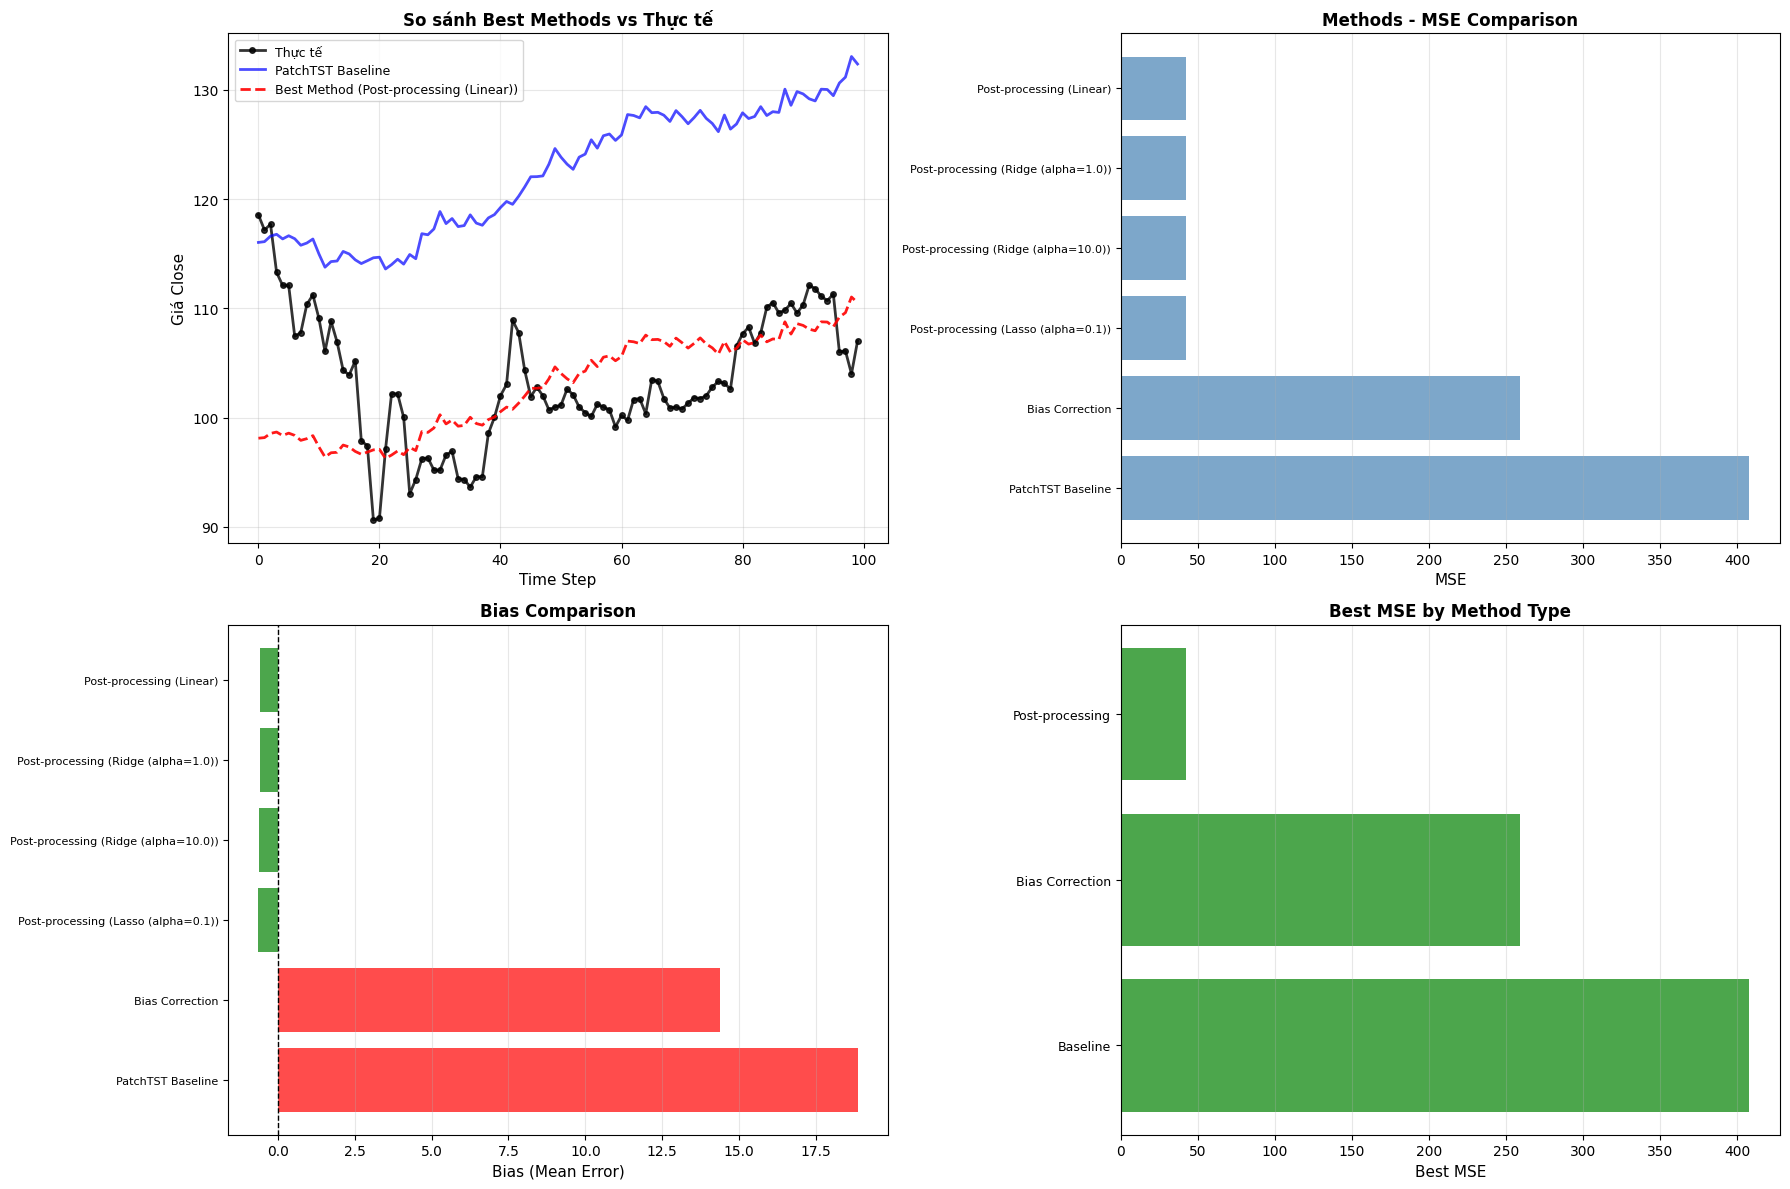

✓ Đã hiển thị biểu đồ so sánh


In [12]:
# Vẽ biểu đồ so sánh best methods
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Predictions vs Actual
ax1 = axes[0, 0]
x_axis = np.arange(len(y_true))
ax1.plot(x_axis, y_true, 'o-', label='Thực tế', linewidth=2, markersize=4, color='black', alpha=0.8)
ax1.plot(x_axis, pred_patchtst_baseline, '-', label='PatchTST Baseline', linewidth=2, alpha=0.7, color='blue')

# Vẽ best method
best_method_name = best_method['Method']
best_pred = best_method_full['Prediction']
ax1.plot(x_axis, best_pred, '--', label=f"Best Method ({best_method_name})", 
         linewidth=2, alpha=0.9, color='red')

ax1.set_xlabel('Time Step', fontsize=11)
ax1.set_ylabel('Giá Close', fontsize=11)
ax1.set_title('So sánh Best Methods vs Thực tế', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: MSE comparison
ax2 = axes[0, 1]
top_methods = comparison_df.head(min(10, len(comparison_df)))
ax2.barh(range(len(top_methods)), top_methods['MSE'].values, color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(top_methods)))
ax2.set_yticklabels(top_methods['Method'].values, fontsize=8)
ax2.set_xlabel('MSE', fontsize=11)
ax2.set_title('Methods - MSE Comparison', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Plot 3: Bias comparison
ax3 = axes[1, 0]
top_bias = comparison_df.head(min(10, len(comparison_df)))
colors_bias = ['red' if b > 0 else 'green' for b in top_bias['Bias'].values]
ax3.barh(range(len(top_bias)), top_bias['Bias'].values, color=colors_bias, alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax3.set_yticks(range(len(top_bias)))
ax3.set_yticklabels(top_bias['Method'].values, fontsize=8)
ax3.set_xlabel('Bias (Mean Error)', fontsize=11)
ax3.set_title('Bias Comparison', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.invert_yaxis()

# Plot 4: Methods by Type
ax4 = axes[1, 1]
type_summary = comparison_df.groupby('Type')['MSE'].min().sort_values()
ax4.barh(range(len(type_summary)), type_summary.values, color='green', alpha=0.7)
ax4.set_yticks(range(len(type_summary)))
ax4.set_yticklabels(type_summary.index.values, fontsize=9)
ax4.set_xlabel('Best MSE', fontsize=11)
ax4.set_title('Best MSE by Method Type', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

plt.tight_layout()
plt.show()

print("✓ Đã hiển thị biểu đồ so sánh")


## 8. Xuất File Submission


In [13]:
print("="*70)
print("💾 XUẤT FILE SUBMISSION")
print("="*70)

# Lấy predictions từ best method
best_method_name = best_method['Method']
final_predictions = best_method_full['Prediction']

print(f"\n📊 Sử dụng phương pháp: {best_method_name}")
print(f"   - MSE: {best_method['MSE']:.4f}")
print(f"   - Bias: {best_method['Bias']:.4f}")

# Đảm bảo có đủ 100 predictions
if len(final_predictions) < horizon:
    print(f"\n⚠️  Chỉ có {len(final_predictions)} predictions, cần {horizon}")
    final_predictions = np.pad(final_predictions, (0, horizon - len(final_predictions)), mode='edge')
    print(f"   ✓ Đã pad lên {len(final_predictions)} predictions")
elif len(final_predictions) > horizon:
    final_predictions = final_predictions[:horizon]
    print(f"\n⚠️  Có {len(final_predictions)} predictions, chỉ lấy {horizon} đầu tiên")

# Đảm bảo không có giá trị âm hoặc NaN
final_predictions = np.maximum(final_predictions, 0)  # Không cho giá trị âm
if np.isnan(final_predictions).any():
    print("   ⚠️  Phát hiện NaN, thay thế bằng giá trị trung bình")
    final_predictions = np.nan_to_num(final_predictions, nan=np.nanmean(final_predictions))

# Tạo submission file
submission = pd.DataFrame({
    "id": np.arange(1, horizon + 1),  # id từ 1 đến 100
    "close": final_predictions
})

# Validation: Kiểm tra format
assert len(submission) == horizon, f"Số dòng phải là {horizon}, nhưng có {len(submission)}"
assert list(submission.columns) == ["id", "close"], f"Columns phải là ['id', 'close'], nhưng có {list(submission.columns)}"
assert submission["id"].min() == 1, f"id phải bắt đầu từ 1, nhưng min là {submission['id'].min()}"
assert submission["id"].max() == horizon, f"id phải kết thúc ở {horizon}, nhưng max là {submission['id'].max()}"
assert not submission["close"].isna().any(), "Không được có NaN trong cột close"
assert (submission["close"] >= 0).all(), "Giá trị close không được âm"

# Tên file submission
method_suffix = best_method_name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('=', '').replace('.', '')
submission_file = f"submission_patchtst_optuna_{method_suffix}.csv"
submission.to_csv(submission_file, index=False)

print(f"\n✓ Đã tạo submission file: {submission_file}")
print(f"   - Shape: {submission.shape}")
print(f"   - Columns: {list(submission.columns)}")

print(f"\n📊 Thống kê predictions:")
print(f"   - Min: {final_predictions.min():.2f}")
print(f"   - Max: {final_predictions.max():.2f}")
print(f"   - Mean: {final_predictions.mean():.2f}")
print(f"   - Std: {final_predictions.std():.2f}")
print(f"   - Median: {np.median(final_predictions):.2f}")

print(f"\n📅 10 dòng đầu:")
print(submission.head(10).to_string(index=False))
print(f"\n📅 10 dòng cuối:")
print(submission.tail(10).to_string(index=False))

print(f"\n✅ Hoàn thành xuất file submission!")


💾 XUẤT FILE SUBMISSION

📊 Sử dụng phương pháp: Post-processing (Linear)
   - MSE: 42.1993
   - Bias: -0.5865

✓ Đã tạo submission file: submission_patchtst_optuna_post-processing_linear.csv
   - Shape: (100, 2)
   - Columns: ['id', 'close']

📊 Thống kê predictions:
   - Min: 96.26
   - Max: 111.03
   - Mean: 102.90
   - Std: 4.40
   - Median: 103.55

📅 10 dòng đầu:
 id     close
  1 98.110168
  2 98.164536
  3 98.548920
  4 98.675110
  5 98.354095
  6 98.574677
  7 98.366882
  8 97.914047
  9 98.067978
 10 98.346680

📅 10 dòng cuối:
 id      close
 91 108.434631
 92 108.095047
 93 107.945618
 94 108.762436
 95 108.740662
 96 108.311234
 97 109.192429
 98 109.599426
 99 111.033859
100 110.512650

✅ Hoàn thành xuất file submission!


## 9. Tổng Kết


In [14]:
print("="*70)
print("📊 TỔNG KẾT VÀ KẾT LUẬN")
print("="*70)

print(f"\n🎯 KẾT QUẢ NGHIÊN CỨU:")
print(f"   - Số phương pháp đã thử: {len(comparison_df)}")
print(f"   - Baseline (PatchTST với Optuna): MSE = {baseline_method['MSE']:.4f}, Bias = {baseline_method['Bias']:.4f}")
print(f"   - Best Method: {best_method['Method']}")
print(f"   - Best MSE: {best_method['MSE']:.4f}")
print(f"   - Best Bias: {best_method['Bias']:.4f}")
print(f"   - Cải thiện MSE: {improvement:+.2f}%")

print(f"\n📈 PHÂN TÍCH THEO TYPE:")
for method_type in comparison_df['Type'].unique():
    type_df = comparison_df[comparison_df['Type'] == method_type]
    best_in_type = type_df.iloc[0]
    print(f"   - {method_type}: {best_in_type['Method']} (MSE: {best_in_type['MSE']:.4f})")

print(f"\n💡 KẾT LUẬN:")
if improvement > 0:
    print(f"   ✓ Phương pháp {best_method['Method']} cải thiện được {improvement:.2f}% so với baseline")
    print(f"   ✓ Bias đã được giảm từ {baseline_method['Bias']:.4f} xuống {best_method['Bias']:.4f}")
    print(f"   ✓ Nên sử dụng: {best_method['Method']} cho submission")
else:
    print(f"   ⚠️  Không có phương pháp nào cải thiện so với baseline")
    print(f"   ⚠️  Có thể cần thử các phương pháp khác hoặc tối ưu hyperparameters")

print(f"\n✓ Hoàn thành nghiên cứu PatchTST với Bias Correction và Optuna!")


📊 TỔNG KẾT VÀ KẾT LUẬN

🎯 KẾT QUẢ NGHIÊN CỨU:
   - Số phương pháp đã thử: 6
   - Baseline (PatchTST với Optuna): MSE = 407.5120, Bias = 18.8494
   - Best Method: Post-processing (Linear)
   - Best MSE: 42.1993
   - Best Bias: -0.5865
   - Cải thiện MSE: +89.64%

📈 PHÂN TÍCH THEO TYPE:
   - Post-processing: Post-processing (Linear) (MSE: 42.1993)
   - Bias Correction: Bias Correction (MSE: 258.8595)
   - Baseline: PatchTST Baseline (MSE: 407.5120)

💡 KẾT LUẬN:
   ✓ Phương pháp Post-processing (Linear) cải thiện được 89.64% so với baseline
   ✓ Bias đã được giảm từ 18.8494 xuống -0.5865
   ✓ Nên sử dụng: Post-processing (Linear) cho submission

✓ Hoàn thành nghiên cứu PatchTST với Bias Correction và Optuna!
